In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from src.paths import RAW_DATA_DIR, PREPROCESSED_DATA_DIR

import warnings
warnings.filterwarnings('ignore')

#### Read data

In [3]:
data_train = pd.read_csv(RAW_DATA_DIR / 'train.csv')
data_test = pd.read_csv(RAW_DATA_DIR / 'test.csv')

# keep both dataframes in one list as we will be applying same transformations to both of them
data_frames = [data_train, data_test]
data_names = ['train', 'test']

for df, name in zip(data_frames, data_names):
    print(f'\n--- {name} data ---\nNumber of rows: {df.shape[0]}\nColumns: {df.columns.to_list()}')
    print(f'Number of nans: {df.isna().sum().sum()}')


--- train data ---
Number of rows: 10506
Columns: ['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent']
Number of nans: 0

--- test data ---
Number of rows: 116293
Columns: ['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']
Number of nans: 0


#### Keep relevant columns
We will drop all the address columns. Trap id and coordinates are sufficient location data. We also ignore number of mosquitos in training data, as it is not given in the test set and virus presence prediction should made before any mosquitos are catched. 

In [4]:
for df in data_frames:
    df.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], axis=1, inplace=True)
    
data_train.drop(['NumMosquitos'], axis=1, inplace=True)

In [5]:
# print columns
for df, name in zip(data_frames, data_names):
    print(f'\n--- {name} data ---\nColumns: {df.columns.to_list()}')


--- train data ---
Columns: ['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'WnvPresent']

--- test data ---
Columns: ['Id', 'Date', 'Species', 'Trap', 'Latitude', 'Longitude']


#### Data types

In [6]:
# inspect data types in dataframes
for df, name in zip(data_frames, data_names):
    print(f'\t{name} data:\n{df.dtypes}\n')

	train data:
Date           object
Species        object
Trap           object
Latitude      float64
Longitude     float64
WnvPresent      int64
dtype: object

	test data:
Id             int64
Date          object
Species       object
Trap          object
Latitude     float64
Longitude    float64
dtype: object



In [7]:
# change 'Date' column format to 'datetime64'
for df in data_frames:
    df['Date'] = pd.to_datetime(df['Date'])

Data types of columns 'Trap' and 'Species' will be addressed later. 

#### Target variable - 'WnvPresent'
0 - virus not present in the sample

1 - virus present in the sample

In [8]:
classes = data_train.WnvPresent.value_counts().to_frame()
classes['percent'] = (classes['count']/classes['count'].sum()*100).round(2).astype('str')+'%'
classes


,count,percent
WnvPresent,,
0,9955,94.76%
1,551,5.24%


The target classes are highly imbalanced. We will undersample class '0' for training. Area under the ROC curve is an appropriate evaluation metric in this case.

### Species

Let's look at virus distribution among different species.

In [9]:
species = data_train.Species.value_counts().to_frame()
species['wnv_present_cnt'] = data_train.groupby('Species').WnvPresent.sum()
species['wnv_present_pct'] = (data_train.groupby('Species').WnvPresent.mean()*100).round(2).astype('str')+'%'
display(species)

,count,wnv_present_cnt,wnv_present_pct
Species,,,
CULEX PIPIENS/RESTUANS,4752,262,5.51%
CULEX RESTUANS,2740,49,1.79%
CULEX PIPIENS,2699,240,8.89%
CULEX TERRITANS,222,0,0.0%
CULEX SALINARIUS,86,0,0.0%
CULEX TARSALIS,6,0,0.0%
CULEX ERRATICUS,1,0,0.0%


We can see that there are 3 main species occuring in large numbers and being infected at some point. We will remove remaining 4 species from our data and assign '0' to all data instances for these 4 species during evaluation.

In [10]:
positive_species = list(species[species.wnv_present_cnt!=0].index)

species2index = {
    positive_species[i]: i for i in range(len(positive_species))
}

for i in range(2):
    data_frames[i] = data_frames[i][data_frames[i]['Species'].isin(positive_species)]
    data_frames[i]['Species'] = data_frames[i]['Species'].map(species2index)


#### Dates
Now we inspect West Nile virus presence across available time span.

In [11]:
# extract date components from 'Date' column
def split_date(df):
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Week'] = df.Date.dt.isocalendar().week
    df['Dayofweek'] = df['Date'].dt.dayofweek
    df['Dayofyear'] = df['Date'].dt.dayofyear

for df in data_frames:
    split_date(df)

Let's look closer at numbers of virus positive cases across years and months.

In [12]:
for col in ['Month', 'Year']:
    display(
        data_frames[0].groupby(col).agg(
            positive_cases = ('WnvPresent', 'sum'),
            percent = ('WnvPresent', lambda x: (x.mean()*100).round(2))
        )
    )

,positive_cases,percent
Month,,
5,0,0.00
6,1,0.07
7,46,1.82
8,377,10.36
9,125,5.82
10,2,0.76


,positive_cases,percent
Year,,
2007,236,6.45
2009,19,0.86
2011,57,2.94
2013,239,10.04


Significant amounts of infections were recorded in the summer months from July to September. Again, we will limit our data to these 3 months and remove other. We will predict '0' to all test instances not in July-September range. 

In [13]:
possible_months = [7,8,9]

for i in range(2):
    data_frames[i] = data_frames[i][data_frames[i]['Month'].isin(possible_months)]

#### Traps

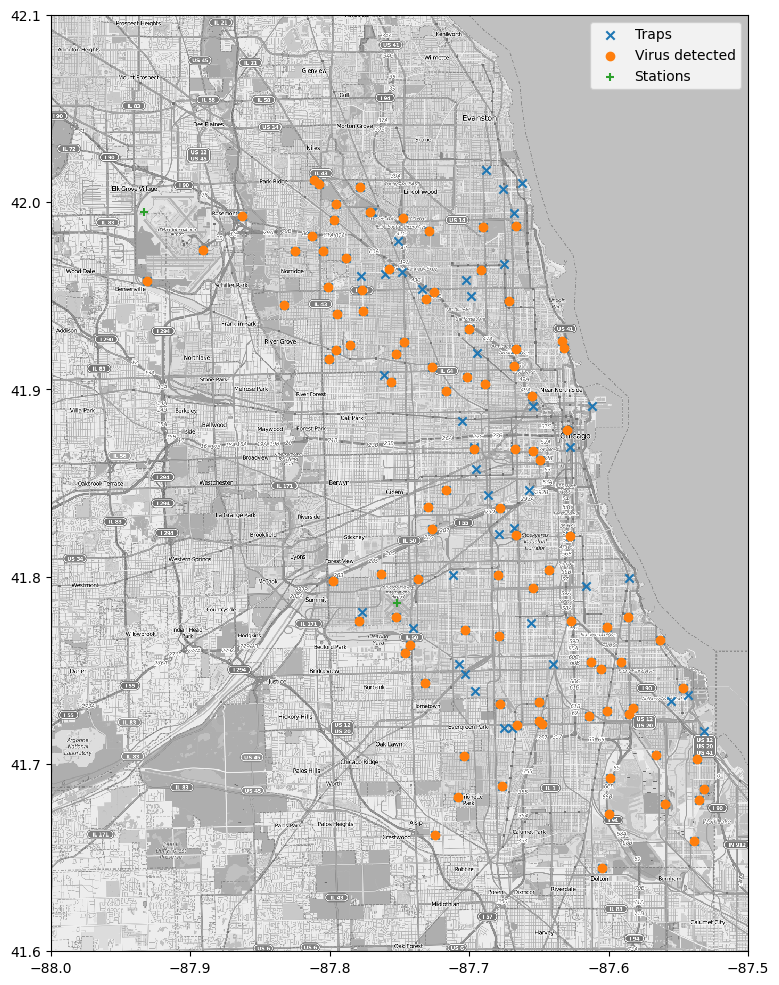

In [14]:
data_train = data_frames[0]
stations = np.array([[-87.933, 41.995],[-87.752, 41.786]])
locations = data_train[['Longitude', 'Latitude']].drop_duplicates().values
locations_wnv = data_train[data_train.WnvPresent!=0][['Longitude', 'Latitude']].drop_duplicates().values

image_arr = np.loadtxt(RAW_DATA_DIR / 'mapdata_copyright_openstreetmap_contributors.txt')
plt.figure(figsize=(9,13))
plt.imshow(image_arr, interpolation='nearest', cmap='gray', extent=(-88, -87.5, 41.6, 42.1), aspect=image_arr.shape[0]/image_arr.shape[1])
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Traps')
plt.scatter(locations_wnv[:,0], locations_wnv[:,1], marker='o', label='Virus detected')
plt.scatter(stations[:,0], stations[:,1], marker='+', label='Stations')
plt.legend()
plt.show()

Many traps never caught any infected mosquito. We will predict '0' for those traps in the data set.

In [15]:
possible_traps = data_train[data_train.WnvPresent!=0].Trap.unique()

for i in range(2):
    data_frames[i] = data_frames[i][data_frames[i].Trap.isin(possible_traps)]

In [16]:
data_frames[0].shape[0], data_frames[1].shape[0]

(7428, 23734)

In [22]:
for df, name in zip(data_frames, data_names):
    df.to_pickle(PREPROCESSED_DATA_DIR / f'{name}.pkl')

In [26]:
data_train = data_frames[0]

data_train.groupby('Trap')['WnvPresent'].agg(['sum', 'mean'])

,sum,mean
Trap,,
T002,18,0.127660
T003,14,0.142857
T005,2,0.166667
T006,4,0.210526
T008,10,0.094340
...,...,...
T233,7,0.162791
T235,7,0.145833
T236,1,0.035714


,Date,Species,Trap,Latitude,Longitude,WnvPresent,Month,Year,Week,Dayofweek,Dayofyear
201,2007-07-02,0,T002,41.954690,-87.800991,0,7,2007,27,0,183
202,2007-07-02,1,T002,41.954690,-87.800991,0,7,2007,27,0,183
205,2007-07-02,0,T015,41.974089,-87.824812,0,7,2007,27,0,183
206,2007-07-02,0,T045,41.921600,-87.666455,0,7,2007,27,0,183
207,2007-07-02,1,T045,41.921600,-87.666455,0,7,2007,27,0,183
...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,0,T035,41.763733,-87.742302,1,9,2013,39,3,269
10502,2013-09-26,0,T231,41.987280,-87.666066,0,9,2013,39,3,269
10503,2013-09-26,0,T232,41.912563,-87.668055,0,9,2013,39,3,269
10504,2013-09-26,0,T233,42.009876,-87.807277,0,9,2013,39,3,269
